# GRADIENT METHODS. AUTOMATIC DIFFERENTIATION

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import integrate
import torch
from torch.autograd import Variable
from sklearn.linear_model import LinearRegression
import time



In [3]:
np.random.seed(0)

In [4]:
 device = 'cuda' if torch.cuda.is_available() else 'cpu'
 print("device = ", device)

device =  cuda


# Linear Regression
## Data:
We are given $n$ points $(x_1,y_1), \ldots, (x_n,y_n)$.
Example: $n=200$:

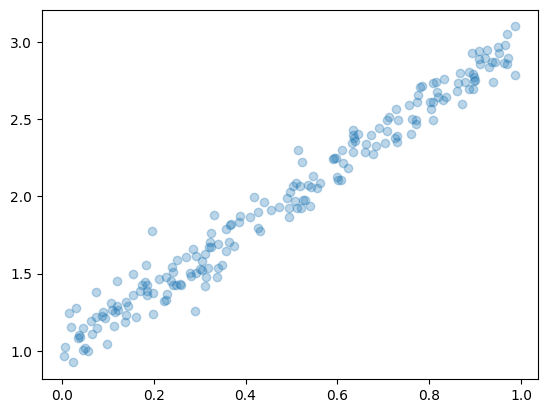

In [5]:
nr_points=200
np.random.seed(42)
x_train = np.random.rand(nr_points, 1)

a_true=2;
b_true=1;
y_train = b_true + a_true * x_train + .1 * np.random.randn(nr_points, 1)



plt.scatter(x_train,y_train,alpha=0.3)

(in descriptioins we abbreviate `x_train` as $x$ and `y_train` as $y$)

Goal: We want to "predict" $y$ given $x$ via finding "best" line. To be more exact, given $x$ we predict $$\hat{y}=ax+b.$$ We want to  find $a, b$ such that
$$error = loss =  f(a,b)={1\over n}\sum_{i=1}^n (\hat{y}_i-y_i)^2 = {1\over n}\sum_{i=1}^n (a x_i + b-y_i)^2$$ is minimalized.

Let us have a look how $f(a,b)$ looks like

drawing $f$, non-Python (slow, two `for` loops) way:

(40, 40)
Running time:  0.041060447692871094  s


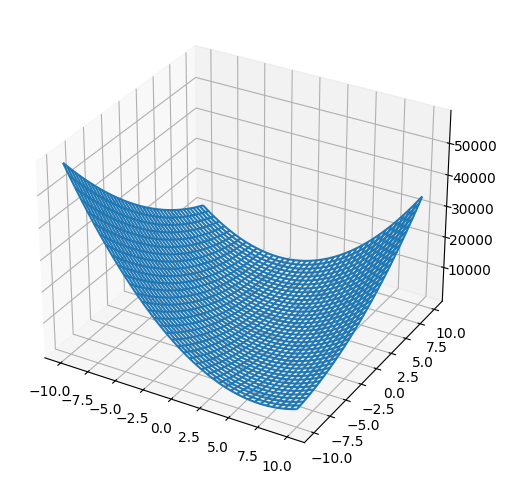

In [6]:


aa = np.linspace(-10,10,40)
bb = np.linspace(-10,10,40)
aa2,bb2=np.meshgrid(aa,bb)
print(aa2.shape)

t_start = time.time()

ff2=np.zeros(aa2.shape)
for i in np.arange(aa2.shape[0]):
  for j in np.arange(aa2.shape[1]):
    ff2[i,j]=np.sum((aa[i]*x_train+bb[j]-y_train)**2)

t_end = time.time()

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')
ax.plot_wireframe(aa2,bb2,ff2)


print("Running time: ", t_end-t_start , " s")

drawing $f$,  Python   way:

Running time:  0.017490148544311523  s


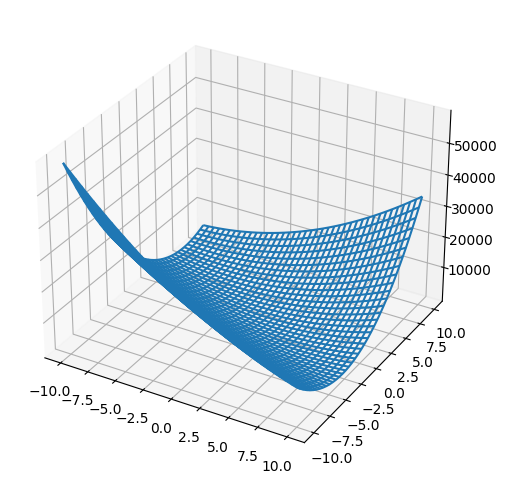

In [7]:

t_start = time.time()

aa2_expanded = aa2[:, np.newaxis, :]  # New shape: (40, 1, 40)
bb2_expanded = bb2[:, np.newaxis, :]  # New shape: (40, 1, 40)

ff2 = np.sum((aa2_expanded * x_train + bb2_expanded - y_train) ** 2, axis=1)
t_end = time.time()

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')
ax.plot_wireframe(aa2,bb2,ff2)


print("Running time: ", t_end-t_start , " s")

# Gradient
In general, we may start with some $(a_0,b_0)$ and ($\rho$ -- learning rate)
$$(a_{t+1}, b_{t+1})  \leftarrow (a_t, b_t) - \rho \nabla f(a,b)|_{a=a_t, b=b_t}$$
In other words:
$$a_{t+1}  \leftarrow a_t - \rho{\partial \over \partial a} f(a,b)|_{a=a_t, b=b_t}$$
$\  $
$$b_{t+1}  \leftarrow b_t - \rho{\partial \over \partial b} f(a,b)|_{a=a_t, b=b_t}$$


## Computing partial derivatives <b>MANUALLY<b>
For this function  
$$ f(a,b)=(\hat{y}_i-y_i)^2 = {1\over n}\sum_{i=1}^n (a x_i + b-y_i)^2$$
$f$ we have
$${\partial\over\partial a} f(a,b)  = {1\over n}\sum_{i=1}^n 2(ax_i+b-y_i) x_i$$
$${\partial\over\partial b} f(a,b)  = {1\over n}\sum_{i=1}^n 2(ax_i+b-y_i) $$

## "Best solution" found -- using <tt>sklearn</tt> library (just to compare with our methods):

In [8]:
linr = LinearRegression()
linr.fit(x_train, y_train)
a_skl = linr.coef_[0].item()
b_skl = linr.intercept_.item()

print("a_skl = ", a_skl, ", b_skl = ", b_skl)

a_skl =  1.9921928931825028 , b_skl =  1.0105201150960823


# Stochastic gradient, tterative updates ($\rho$ - learning rate):
$$a_{t+1}  \leftarrow a_t - \rho{\partial \over \partial a} f(a,b)|_{a=a_t, b=b_t},\qquad \qquad
b_{t+1}  \leftarrow b_t - \rho{\partial \over \partial b} f(a,b)|_{a=a_t, b=b_t}$$

-0.4167578474054706 -0.056266827226329474


Text(0.5, 1.0, 'Loss (every 10 epochs)')

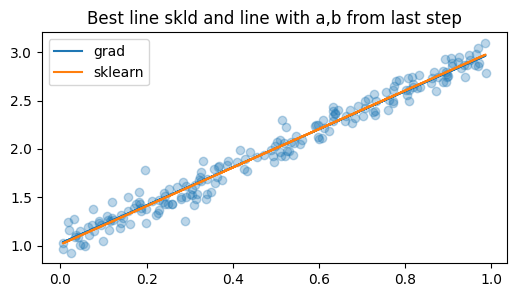

<Figure size 640x480 with 0 Axes>

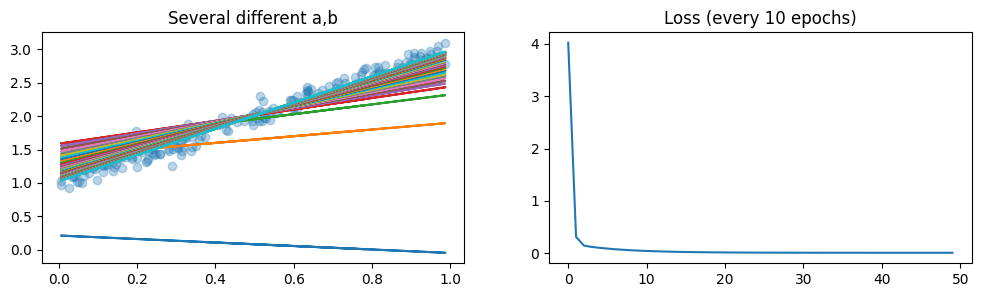

In [9]:
lr = 0.06
n_epochs = 500

loss_list = []
a_list =[]
b_list =[]

# random inital a, b
np.random.seed(2)
a = np.random.normal(0,1)
b = np.random.normal(0,1)
print(a,b)

# main iteration:
for epoch in range(n_epochs):
  grad_a = 2*np.mean((a*x_train+b-y_train)*x_train)    ## <- Again, we computed derivatives MANUALLY
  grad_b = 2*np.mean(a*x_train+b-y_train)

  a = a - lr*grad_a
  b = b - lr*grad_b

  #below is just for later figures:
  if ((epoch % 10)==0):
    a_list.append(a)
    b_list.append(b)
    loss = np.mean((a * x_train + b-y_train)**2)
    loss_list.append(loss.item())


plt.figure(figsize=(6,3))
plt.scatter(x_train,y_train,alpha=0.3)
plt.plot(x_train,a*x_train+b, label = "grad")
plt.plot(x_train ,a_skl*x_train +b_skl, label = "sklearn")
plt.title("Best line skld and line with a,b from last step")
plt.legend()

plt.figure()
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))

axes[0].scatter(x_train,y_train,alpha=0.3)
axes[0].set_title("Several different a,b")
for i in np.arange(len(a_list)):

  aa=a_list[i]
  bb=b_list[i]
  axes[0].plot(x_train,aa*x_train+bb)

axes[1].plot(np.arange(len(loss_list)),loss_list)
axes[1].set_title("Loss (every 10 epochs)")

# Automatic differentation in torch

Again, mannually: $$  f(a,b)={1\over n}\sum_{i=1}^n (\hat{y}_i-y_i)^2 = {1\over n}\sum_{i=1}^n (a x_i + b-y_i)^2$$
$${\partial\over\partial a} f(a,b)  = {1\over n}\sum_{i=1}^n 2(ax_i+b-y_i) x_i$$
$${\partial\over\partial b} f(a,b)  = {1\over n}\sum_{i=1}^n 2(ax_i+b-y_i) $$

Compute *MANUALLY* values of gradients at `a=2.0` and `b=4.0`

In [10]:
a=2.0
b=4.0

print("grad_a = ", 2*np.mean((a*x_train+b-y_train)*x_train))
print("grad_b = ",2*np.mean(a*x_train+b-y_train))

grad_a =  2.898862652293246
grad_b =  5.986517146534729


### a_tensor, b_tensor -- type "tensor", gradients will be computed:

In [11]:
# type 'tensor', can comptute gradients
a_tensor = torch.tensor(2.0, requires_grad=True)
b_tensor = torch.tensor(4.0, requires_grad=True)
print("a_tensor = ", a_tensor,", b_tensor = ", b_tensor)

a_tensor =  tensor(2., requires_grad=True) , b_tensor =  tensor(4., requires_grad=True)


We also need

In [12]:
x_train_tensor = torch.from_numpy(x_train).float().to(device)
y_train_tensor = torch.from_numpy(y_train).float().to(device)

Define  $loss$ (function $f$)

In [13]:
yhat = a_tensor * x_train_tensor + b_tensor
error = y_train_tensor - yhat
loss = torch.mean((error ** 2))
# == loss = torch.mean(torch.pow(x_train_tensor*a_tensor+b_tensor-y_train_tensor,2))
loss.backward()

print("grad_a (torch) = ", a_tensor.grad)
print("grad_b (torch) = ", b_tensor.grad)

print()

grad_a (torch) =  tensor(2.8989)
grad_b (torch) =  tensor(5.9865)



tensor([-0.9876], device='cuda:0', requires_grad=True) tensor([0.8938], device='cuda:0', requires_grad=True)
3.20788836479187
2.4403767585754395
1.8841073513031006
1.480422019958496
1.1869593858718872
0.9731277227401733
0.8168337941169739
0.7021225094795227
0.6174707412719727
0.5545568466186523
0.5073708295822144
0.47157156467437744
0.4440240263938904
0.4224635362625122
0.4052541255950928
0.3912140429019928
0.37948939204216003
0.3694630265235901
0.36068883538246155
0.35284423828125
0.34569594264030457
0.339074969291687
0.3328588902950287
0.32695892453193665
0.32131052017211914
0.3158667981624603
0.3105933666229248
0.30546510219573975
0.30046346783638
0.29557478427886963
0.2907887101173401
0.2860974967479706
0.28149521350860596
0.27697718143463135
0.27253973484039307
0.2681799530982971
0.2638952434062958
0.2596835792064667
0.25554314255714417
0.25147223472595215
0.2474694550037384
0.2435334324836731
0.23966288566589355
0.23585660755634308
0.23211343586444855
0.22843225300312042
0.224812

Text(0.5, 1.0, 'Loss (every 10 epochs)')

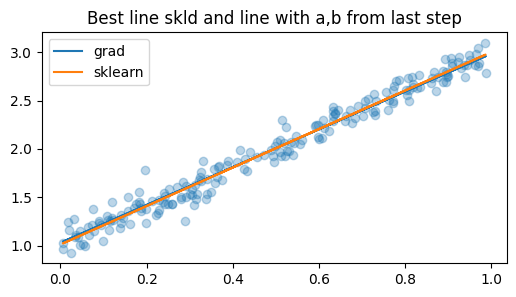

<Figure size 640x480 with 0 Axes>

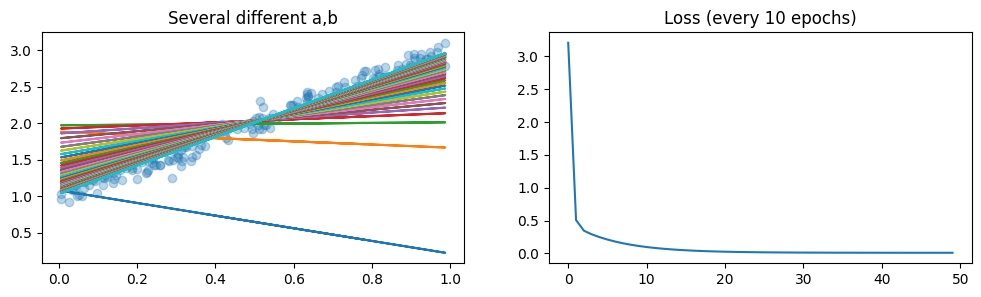

In [14]:
lr = 0.06
n_epochs = 500

loss_list = []
a_list =[]
b_list =[]

# random inital a, b

a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
print(a,b)


optimizer = torch.optim.SGD([a, b], lr=lr) # Stochastic Gradiend Descent
# optimizer = torch.optim.Adam([a, b], lr=lr) # More sophisticated method


# main iteration:
for epoch in range(n_epochs):

  yhat = a  * x_train_tensor + b
  error = y_train_tensor - yhat
  loss = torch.mean((error ** 2))
  print(loss.item())

  loss.backward()

  optimizer.step()
  optimizer.zero_grad()

  #below is just for later figures:
  if ((epoch % 10)==0):
    a_list.append(a.item())
    b_list.append(b.item())
    #loss = np.mean((a * x_train + b-y_train)**2)
    loss_list.append(loss.item())


plt.figure(figsize=(6,3))
plt.scatter(x_train,y_train,alpha=0.3)
plt.plot(x_train,a.item()*x_train+b.item(), label = "grad")
plt.plot(x_train ,a_skl*x_train +b_skl, label = "sklearn")
plt.title("Best line skld and line with a,b from last step")
plt.legend()

plt.figure()
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))

axes[0].scatter(x_train,y_train,alpha=0.3)
axes[0].set_title("Several different a,b")
for i in np.arange(len(a_list)):

  aa=a_list[i]
  bb=b_list[i]
  axes[0].plot(x_train,aa*x_train+bb)

axes[1].plot(np.arange(len(loss_list)),loss_list)
axes[1].set_title("Loss (every 10 epochs)")

In [15]:
print(a.item(), b.item())
print(a_skl, b_skl)

1.9565099477767944 1.0290733575820923
1.9921928931825028 1.0105201150960823


# Q5.1
* Sample `x_test`, a vector of size 50 of i.i.d $\mathcal{U}(0,1)$ random variables and similarly compute corresponding

$\qquad$ `y_test = b_true + a_true * x_test + .1 * np.random.randn(nr_points, 1)`

* Take the model (aka `a` and `b`) trained on `(x_train,y_train)` and compute final loss on test set, i.e.,
$$loss_{final} = {1\over n}\sum_{i=1}^{50} (a\cdot x\_{test} + b - y_{test})^2$$
* Using SGD or Adam find new $a$ and $b$ minimizing function
$$g(a,b)={1\over n}\sum_{i=1}^n (\hat{y}_i-y_i)^2 + \lambda(a^2+b^2)$$
with $\lambda=0.1$
* Can you also optimze  somehow  for `lambda>0`?

In [16]:
import numpy as np


nr_points = 50

x_test = np.random.uniform(0, 1, size=(nr_points, 1))
y_test = b_true + a_true * x_test + 0.1 * np.random.randn(nr_points, 1)

a=a.item()
b=b.item()

loss=np.mean([(a*x_test+b-y_test)**2])
print(loss)



0.01118285778405391


Text(0.5, 1.0, 'Loss (every 10 epochs)')

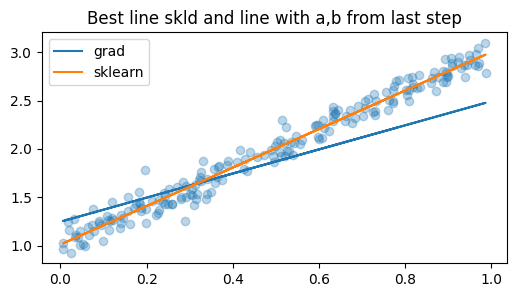

<Figure size 640x480 with 0 Axes>

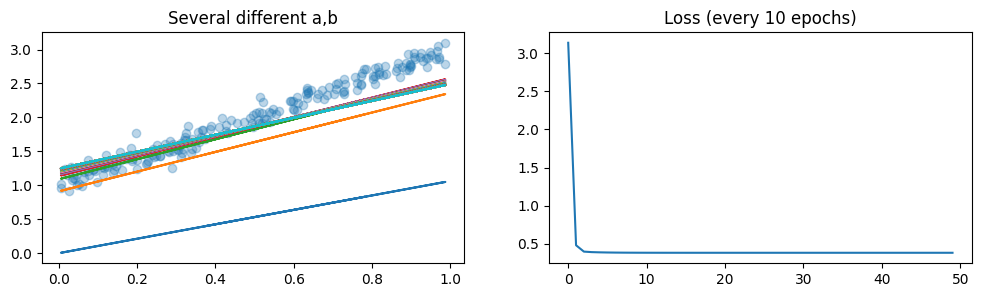

In [17]:
lr = 0.06
n_epochs = 500

loss_list = []
a_list =[]
b_list =[]

# random inital a, b

a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)

optimizer = torch.optim.SGD([a, b], lr=lr) # Stochastic Gradiend Descent
# optimizer = torch.optim.Adam([a, b], lr=lr) # More sophisticated method

lam=0.1

# main iteration:
for epoch in range(n_epochs):

  yhat = a  * x_train_tensor + b
  error = y_train_tensor - yhat
  loss = torch.mean((error ** 2))+lam*(a**2+b**2)
  #print(loss.item())

  loss.backward()

  optimizer.step()
  optimizer.zero_grad()

  #below is just for later figures:
  if ((epoch % 10)==0):
    a_list.append(a.item())
    b_list.append(b.item())
    loss_list.append(loss.item())


plt.figure(figsize=(6,3))
plt.scatter(x_train,y_train,alpha=0.3)
plt.plot(x_train,a.item()*x_train+b.item(), label = "grad")
plt.plot(x_train ,a_skl*x_train +b_skl, label = "sklearn")
plt.title("Best line skld and line with a,b from last step")
plt.legend()

plt.figure()
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))

axes[0].scatter(x_train,y_train,alpha=0.3)
axes[0].set_title("Several different a,b")
for i in np.arange(len(a_list)):

  aa=a_list[i]
  bb=b_list[i]
  axes[0].plot(x_train,aa*x_train+bb)

axes[1].plot(np.arange(len(loss_list)),loss_list)
axes[1].set_title("Loss (every 10 epochs)")

7.867303848266602
5.768567085266113
4.37297248840332
3.4226932525634766
2.7613000869750977
2.2907466888427734
1.9483072757720947
1.6932437419891357
1.498758316040039
1.3470046520233154
1.225948691368103
1.127366542816162
1.0455585718154907
0.9765153527259827
0.9173714518547058
0.8660457730293274
0.8210018277168274
0.7810852527618408
0.745415449142456
0.7133089303970337
0.684227705001831
0.6577414274215698
0.6335016489028931
0.6112224459648132
0.5906665921211243
0.5716353058815002
0.5539600849151611
0.5374974012374878
0.5221238732337952
0.5077323913574219
0.4942299723625183
0.48153504729270935
0.46957576274871826
0.4582887291908264
0.44761770963668823
0.4375123977661133
0.42792782187461853
0.41882380843162537
0.4101641774177551
0.4019162058830261
0.3940503001213074
0.3865396976470947
0.3793598413467407
0.37248870730400085
0.3659059703350067
0.35959309339523315
0.3535330891609192
0.34771034121513367
0.3421105444431305
0.33672040700912476
0.3315278887748718
0.3265215754508972
0.3216911554

Text(0.5, 1.0, 'Loss (every 10 epochs)')

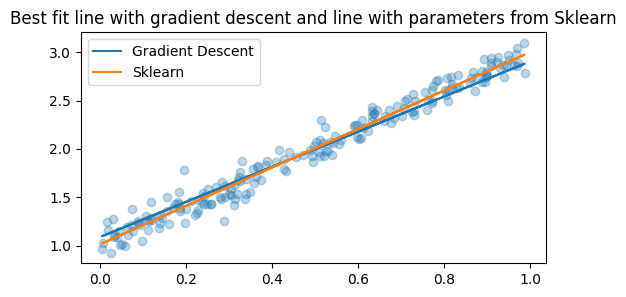

<Figure size 640x480 with 0 Axes>

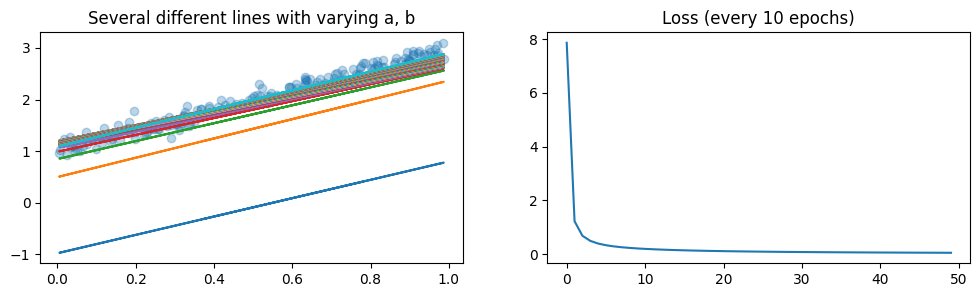

In [18]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

lr = 0.06
n_epochs = 500

loss_list = []
a_list = []
b_list = []
lambda_list = []


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)

lambda_tensor = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)

optimizer = torch.optim.SGD([a, b, lambda_tensor], lr=lr)


for epoch in range(n_epochs):
    yhat = a * x_train_tensor + b
    error = y_train_tensor - yhat
    regularization_term = F.softplus(lambda_tensor) * (a ** 2 + b ** 2)
    loss = torch.mean((error ** 2)) + regularization_term
    print(loss.item())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # Store values for later visualization
    if (epoch % 10) == 0:
        a_list.append(a.item())
        b_list.append(b.item())
        lambda_list.append(lambda_tensor.item())
        loss_list.append(loss.item())

# Visualization
plt.figure(figsize=(6, 3))
plt.scatter(x_train, y_train, alpha=0.3)
plt.plot(x_train, a.item() * x_train + b.item(), label="Gradient Descent")
plt.plot(x_train, a_skl * x_train + b_skl, label="Sklearn")
plt.title("Best fit line with gradient descent and line with parameters from Sklearn")
plt.legend()

plt.figure()
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))

axes[0].scatter(x_train, y_train, alpha=0.3)
axes[0].set_title("Several different lines with varying a, b")
for i in np.arange(len(a_list)):
    aa = a_list[i]
    bb = b_list[i]
    axes[0].plot(x_train, aa * x_train + bb)

axes[1].plot(np.arange(len(loss_list)), loss_list)
axes[1].set_title("Loss (every 10 epochs)")


Text(0.5, 1.0, 'Loss (every 10 epochs)')

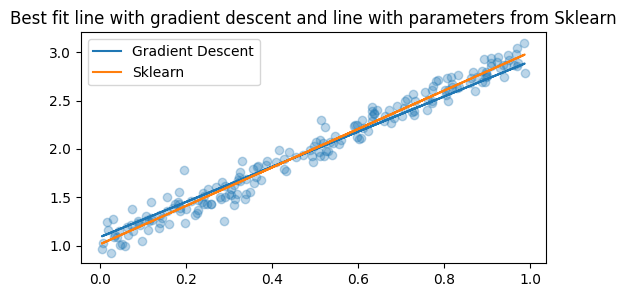

<Figure size 640x480 with 0 Axes>

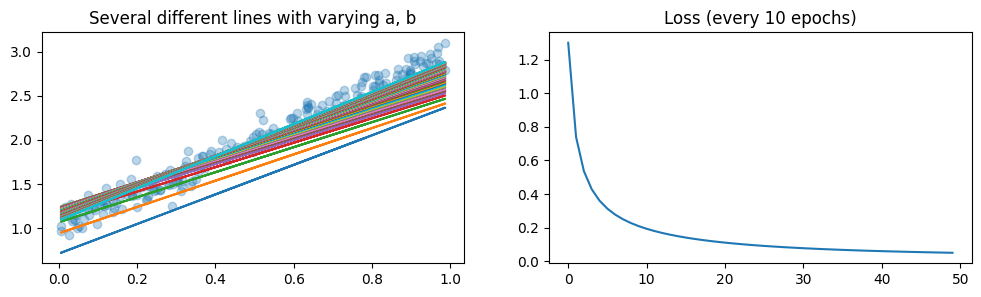

In [19]:
import torch
import matplotlib.pyplot as plt
import numpy as np


lr = 0.06
n_epochs = 500

loss_list = []
a_list = []
b_list = []
lambda_list = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)

lambda_tensor = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)

optimizer = torch.optim.SGD([a, b, lambda_tensor], lr=lr)

for epoch in range(n_epochs):
    yhat = a * x_train_tensor + b
    error = y_train_tensor - yhat
    regularization_term = torch.exp(lambda_tensor) * (a ** 2 + b ** 2)
    loss = torch.mean((error ** 2)) + regularization_term

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # Store values for later visualization
    if (epoch % 10) == 0:
        a_list.append(a.item())
        b_list.append(b.item())
        lambda_list.append(lambda_tensor.item())
        loss_list.append(loss.item())

# Visualization
plt.figure(figsize=(6, 3))
plt.scatter(x_train, y_train, alpha=0.3)
plt.plot(x_train, a.item() * x_train + b.item(), label="Gradient Descent")
plt.plot(x_train, a_skl * x_train + b_skl, label="Sklearn")
plt.title("Best fit line with gradient descent and line with parameters from Sklearn")
plt.legend()

plt.figure()
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))

axes[0].scatter(x_train, y_train, alpha=0.3)
axes[0].set_title("Several different lines with varying a, b")
for i in np.arange(len(a_list)):
    aa = a_list[i]
    bb = b_list[i]
    axes[0].plot(x_train, aa * x_train + bb)

axes[1].plot(np.arange(len(loss_list)), loss_list)
axes[1].set_title("Loss (every 10 epochs)")


# Many more parameters to optimize.. e.g., **matrices**
Parameters we optimize do not have to be scalars, they can be vectors, matrices,...

Say we are given $\mathbf{Z}$ of size $n\times d$ and want to represent it as
$$\mathbf{Z}\approx \mathbf{W}\mathbf{H}$$
where $\mathbf{W}$ is of size $n\times r$ and $\mathbf{H}$ is of size $r\times d$

No restrictions on entries of $\mathbf{W}$ and $\mathbf{H}$, goal is to minimize some $dist(\mathbf{Z},\mathbf{W}\mathbf{H})$, e.g. Frob:
 $$dist_{Frob}(\mathbf{Z},\mathbf{W}\mathbf{H})=||\mathbf{Z}-\mathbf{W}\mathbf{H}||^2=\sum_{i,j} (\mathbf{Z}[i,j] -(\mathbf{W}\mathbf{H})[i,j])^2$$

In [23]:
d=15
n=11
Z = torch.randint(0,10,(n,d))
Z=Z.to('cuda')
print(Z)

tensor([[5, 3, 8, 5, 7, 0, 1, 7, 9, 6, 1, 7, 7, 8, 7],
        [6, 0, 1, 6, 5, 6, 2, 6, 8, 1, 7, 4, 6, 4, 6],
        [2, 7, 9, 0, 1, 6, 0, 0, 3, 1, 4, 9, 4, 6, 0],
        [2, 1, 3, 2, 3, 0, 9, 2, 1, 9, 2, 7, 3, 1, 0],
        [0, 8, 6, 9, 5, 4, 4, 2, 6, 8, 0, 7, 4, 6, 9],
        [9, 3, 0, 9, 0, 8, 9, 0, 7, 3, 7, 6, 8, 8, 1],
        [8, 5, 0, 3, 8, 4, 9, 0, 5, 5, 2, 0, 1, 3, 8],
        [1, 1, 7, 7, 6, 5, 4, 3, 1, 3, 1, 8, 5, 7, 0],
        [4, 6, 6, 6, 5, 5, 4, 7, 6, 5, 3, 8, 4, 9, 2],
        [3, 9, 5, 7, 7, 4, 0, 6, 1, 9, 3, 0, 4, 4, 1],
        [8, 0, 0, 1, 6, 8, 9, 8, 2, 2, 7, 8, 1, 4, 4]], device='cuda:0')


Set r, sample random matrices  $\mathbf{H}, \mathbf{W}$  (each entry  $\mathcal{N}$(0,1)  i.i.d)

In [24]:
r=2
W = torch.randn((n,r), requires_grad=True, dtype=torch.float, device=device)
H = torch.randn((r,d), requires_grad=True, dtype=torch.float, device=device)
print(W,"\n",H)

tensor([[ 0.8712,  0.3881],
        [-0.1882, -0.4232],
        [ 2.5789, -0.1109],
        [-0.2915,  0.4625],
        [ 1.4477,  1.0305],
        [ 0.4406, -0.7241],
        [-0.1172, -0.4852],
        [ 1.5153, -0.5842],
        [-0.8439,  0.6313],
        [-0.4607, -0.8214],
        [ 1.4642,  0.3220]], device='cuda:0', requires_grad=True) 
 tensor([[ 0.2800, -0.4063,  0.4378,  1.2176, -1.4405,  0.5792,  1.5573, -0.6157,
         -0.4420, -1.1616, -0.2546, -0.5482,  0.6342, -0.4101,  0.7113],
        [ 0.3813, -0.9138, -0.1210, -2.4684,  2.8619, -1.4062,  0.0798,  0.2566,
         -0.2443,  0.7141, -0.9050, -0.8240, -2.2395,  0.2199, -0.3148]],
       device='cuda:0', requires_grad=True)


In [25]:
loss=torch.sum(torch.pow(Z-torch.matmul(W,H),2))
print(loss)

tensor(4872.1304, device='cuda:0', grad_fn=<SumBackward0>)


Nr of parameters = n*r+r*d=

In [26]:
print("Nr of parameters in Z : ", n*d)
print("Nr of parameters in H and W : ",n*r+r*d)
print("Fraction/reduction: ", np.round((n*r+r*d)/(n*d),4))

Nr of parameters in Z :  165
Nr of parameters in H and W :  52
Fraction/reduction:  0.3152


tensor(4.5438, device='cuda:0', grad_fn=<MeanBackward0>)
final loss2 =  4.543788909912109


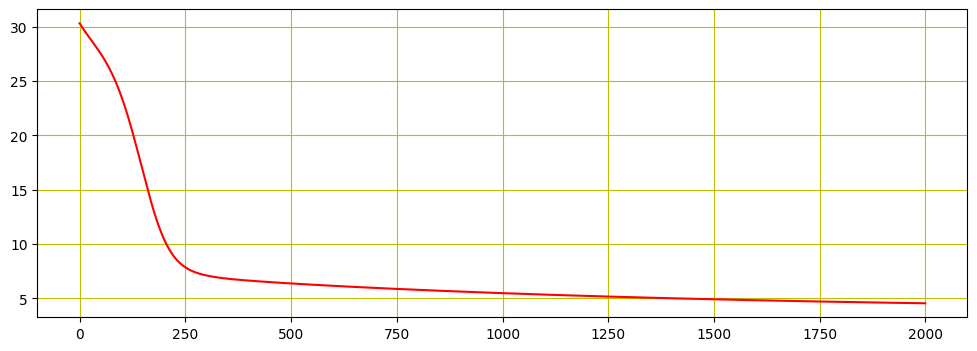

In [27]:

lr = 0.02
n_epochs = 2000

r=3
W = torch.randn((n,r), requires_grad=True, dtype=torch.float, device=device)
H = torch.randn((r,d), requires_grad=True, dtype=torch.float, device=device)


optimizer = torch.optim.SGD([W, H], lr=lr)
#optimizer = torch.optim.Adam([W, H], lr=lr)

loss_list = []

for epoch in range(n_epochs):

    # just define loss! everything less automatic
    loss=torch.mean(torch.pow(Z-torch.matmul(W,H),2))   ## <- MAIN ONE


    loss.backward()

    optimizer.step()
    optimizer.zero_grad()
    loss_list.append(loss.item())

print(loss)


#fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,4))
plt.figure(figsize=(12,4))
plt.plot(loss_list, 'r')
plt.grid('True', color='y')


final_loss=loss.item()
print("final loss2 = ", loss.item())


In [28]:
print("W = ", W, "\nH=",H)

W =  tensor([[-0.2146,  3.2030, -0.0641],
        [ 1.0993,  1.9819,  1.8607],
        [ 1.5396,  1.0682, -0.5979],
        [ 1.0448,  1.0753, -1.1141],
        [ 0.0655,  2.8749, -1.3106],
        [ 3.4676,  1.0572,  0.9258],
        [ 0.4736,  1.9773,  0.2000],
        [ 1.2290,  1.6107, -0.5473],
        [ 1.1920,  2.3755, -0.2130],
        [ 0.0686,  2.2131, -1.1868],
        [ 1.9317,  1.5027,  1.6033]], device='cuda:0', requires_grad=True) 
H= tensor([[ 1.5876,  0.8637,  0.4621,  1.2144, -0.4468,  2.0944,  2.5198, -0.3712,
          0.2521,  0.6573,  1.6811,  2.1738,  1.4983,  1.5612, -1.0558],
        [ 1.3973,  1.5380,  1.8263,  2.0250,  2.6989,  1.1820,  0.9338,  2.1789,
          2.2910,  2.0232,  0.7796,  1.7855,  1.4283,  2.0569,  2.4538],
        [ 1.3456, -2.1760, -1.7159, -0.5500,  0.3854,  0.6841, -0.5714,  1.3729,
          1.3733, -2.2523,  1.2634, -0.6210, -0.3013, -0.2492,  1.2283]],
       device='cuda:0', requires_grad=True)


Recovered $\mathbf{Z}$:


In [33]:

print("Recovered (rounded) Z, i.e., W*H = \n ",np.round(torch.matmul(W,H).cpu().detach().numpy(),2))
print("Original Z = \n ",np.round(Z.cpu().detach().numpy(),2))
print(np.round((torch.matmul(W,H).cpu().detach().numpy()-Z.cpu().detach().numpy())/Z.cpu().detach().numpy(),2))


Recovered (rounded) Z, i.e., W*H = 
  [[ 4.05  4.88  5.86  6.26  8.72  3.29  2.49  6.97  7.2   6.48  2.06  5.29
   4.27  6.27  8.01]
 [ 7.02 -0.05  0.93  4.33  5.57  5.92  3.56  6.46  7.37  0.54  5.74  4.77
   3.92  5.33  5.99]
 [ 3.13  4.27  3.69  4.36  1.96  4.08  5.22  0.94  2.01  4.52  2.67  5.63
   4.01  4.75  0.26]
 [ 1.66  4.98  4.36  4.06  2.01  2.7   4.27  0.43  1.2   5.37  1.19  4.88
   3.44  4.12  0.17]
 [ 2.36  7.33  7.53  6.62  7.22  2.64  3.6   4.44  4.8   8.81  0.7   6.09
   4.6   6.34  5.38]
 [ 8.23  2.61  1.94  5.84  1.66  9.15  9.2   2.29  4.57  2.33  7.82  8.85
   6.43  7.36  0.07]
 [ 3.78  3.01  3.49  4.47  5.2   3.47  2.93  4.41  4.92  3.86  2.59  4.44
   3.47  4.76  4.6 ]
 [ 3.47  4.73  4.45  5.06  3.59  4.1   4.91  2.3   3.25  5.3   2.63  5.89
   4.31  5.37  1.98]
 [ 4.93  5.15  5.25  6.38  5.8   5.16  5.34  4.44  5.45  6.07  3.59  6.96
   5.24  6.8   4.31]
 [ 1.6   6.05  6.11  5.22  5.48  1.95  2.92  3.17  3.46  7.2   0.34  4.84
   3.62  4.95  3.9 ]
 [ 7.32  0.4

<ipython-input-33-02a77dd6ca38>:3: RuntimeWarning: divide by zero encountered in divide
  print(np.round((torch.matmul(W,H).cpu().detach().numpy()-Z.cpu().detach().numpy())/Z.cpu().detach().numpy(),2))


# Q5.2
* Perform Truncated SVD, i.e., decompose $\mathbf{Z}=\mathbf{U}\mathbf{\Lambda}^{1\over 2} \mathbf{V}^T$, denote $\mathbf{W}=\mathbf{U}, \mathbf{H}=\mathbf{\Lambda}^{1\over 2} \mathbf{V}^T$. Then approximate $\mathbf{Z}$ by $\mathbf{Z}_r=\mathbf{W}_r \mathbf{H}_r$. Compare with SGD/Adam methods for various values of $r$. What are the conclusions?
* Consider different distance
 $$dist_{4}(\mathbf{Z},\mathbf{W}\mathbf{H})=\sum_{i,j} (\mathbf{Z}[i,j] -(\mathbf{W}\mathbf{H})[i,j])^4$$
 Find "best" matrices $\mathbf{W}, \mathbf{H}$ using SGD/Adam methods. Compare with distance computed for truncated SVD.


In [46]:
from sklearn.decomposition import TruncatedSVD
import numpy as np

def svd(Z,r):
  svd = TruncatedSVD(n_components=r)
  svd.fit(Z)
  Sigma2 = np.diag(svd.singular_values_)
  VT = svd.components_
  W = svd.transform(Z) / svd.singular_values_
  H = np.dot(Sigma2, VT)
  return np.dot(W,H)



def sgd(Z,r):
  lr = 0.02
  n_epochs = 2000
  W = torch.randn((n,r), requires_grad=True, dtype=torch.float, device=device)
  H = torch.randn((r,d), requires_grad=True, dtype=torch.float, device=device)
  #optimizer = torch.optim.SGD([W, H], lr=lr)
  optimizer = torch.optim.Adam([W, H], lr=lr)

  for epoch in range(n_epochs):

      loss=torch.mean(torch.pow(Z-torch.matmul(W,H),2))
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
  return torch.matmul(W,H).cpu().detach().numpy()



from sklearn.metrics import mean_squared_error
for i in range (2,16):
  print(i)
  Z_org=Z.cpu().detach().numpy()
  #print(svd(Z_org,i).dtype)
  #print("SGD: ", np.linalg.norm(sgd(Z, i)-Z_org, 'fro'))
  #print("SVD: ", np.linalg.norm(svd(Z, i)-Z_org, 'fro'))
  print("SVD", mean_squared_error(svd(Z_org,i), Z_org))
  print("SGD", mean_squared_error(sgd(Z,i), Z_org))


2
SVD 5.375236123022511
SGD 5.375236079368515
3
SVD 3.880873708439975
SGD 3.880873703342998
4
SVD 2.8188341891232933
SGD 2.818834191978989
5
SVD 1.9260450316457052
SGD 1.9260450953841177
6
SVD 1.23183737624432
SGD 1.2318373598429646
7
SVD 0.672706783870581
SGD 0.6727068299739468
8
SVD 0.35578532642688204
SGD 0.3557852818914237
9
SVD 0.15085859488614636
SGD 0.15085859266610133
10
SVD 0.018613212390263312
SGD 0.01861321149503159
11
SVD 4.783670811132565e-29
SGD 3.508647390201258e-06
12
SVD 3.40662725680896e-29
SGD 6.849800349324753e-13
13
SVD 2.98731988964191e-29
SGD 2.1007801979481635e-13
14
SVD 1.2507646570139297e-29
SGD 2.5084770645347333e-13
15
SVD 1.8797748167113987e-29
SGD 1.2366709087750827e-13


In [52]:
def sgd4(Z,r):
  lr = 0.02 #mniejszy lr, bo byl nan
  n_epochs = 2000
  W = torch.randn((n,r), requires_grad=True, dtype=torch.float, device=device)
  H = torch.randn((r,d), requires_grad=True, dtype=torch.float, device=device)
  #optimizer = torch.optim.SGD([W, H], lr=lr)
  optimizer = torch.optim.Adam([W, H], lr=lr)

  for epoch in range(n_epochs):

      loss=torch.mean(torch.pow(Z-torch.matmul(W,H),4))
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
  return torch.matmul(W,H).cpu().detach().numpy()




for i in range (2,16):
  print(i)
  Z_org=Z.cpu().detach().numpy()
  print("SGD: ", np.linalg.norm(sgd(Z, i)-Z_org, 'fro'))
  print("SGD4: ", np.linalg.norm(sgd4(Z, i)-Z_org, 'fro'))
  print("SVD: ", np.linalg.norm(svd(Z_org, i)-Z_org, 'fro'))

2
SGD:  29.781100727221652
SGD4:  30.767784628353166
SVD:  29.781100723423812
3
SGD:  25.30502249853732
SGD4:  26.54933692696368
SVD:  25.305022463783665
4
SGD:  21.566354484483462
SGD4:  22.872902306581143
SVD:  21.566354379109686
5
SGD:  17.826873697019963
SGD4:  20.271973945850924
SVD:  17.826873820766817
6
SGD:  14.256688174126294
SGD4:  15.935890790943716
SVD:  14.256688503306538
7
SGD:  10.535493835115044
SGD4:  11.924445667788476
SVD:  10.535493312543359
8
SGD:  7.6618912844252245
SGD4:  9.605951377637744
SVD:  7.661891337028707
9
SGD:  4.989155079145908
SGD4:  9.035008990506878
SVD:  4.98915505433677
10
SGD:  1.7524781359508932
SGD4:  6.906092677039678
SVD:  1.7524782578946434
11
SGD:  1.3560883593760248e-05
SGD4:  7.362326701708306
SVD:  8.942489609757883e-14
12
SGD:  1.2670049121164365e-05
SGD4:  5.010064906958643
SVD:  5.746531227025136e-14
13
SGD:  1.946553585860242e-05
SGD4:  5.668279607182627
SVD:  5.2497974984903596e-14
14
SGD:  6.660002273259691e-06
SGD4:  5.00107635361

## Non-negative matrices Matrices  $\mathbf{W},\mathbf{H} $

Note that currently found matrices are NOT non-negative

In [ ]:
print(W,"\n",H)

tensor([[ 1.2480, -1.0894, -1.9797],
        [ 1.0086, -0.0693, -1.8559],
        [ 2.9752,  0.4244, -0.3684],
        [ 0.6423,  0.7221, -2.2588],
        [ 1.1210, -2.1106, -1.8943],
        [ 1.6697,  0.7928, -1.3774],
        [ 1.2752,  0.9145, -2.7965],
        [ 1.5168, -1.7827, -2.1605],
        [ 1.0151,  1.4475, -1.7634],
        [ 3.4433, -0.7442,  0.2327],
        [ 1.4965, -1.0992, -0.7134]], requires_grad=True) 
 tensor([[ 1.8419,  2.2138,  0.7991,  2.0159,  0.6691,  2.3804,  1.8929,  0.4473,
          0.3039,  0.2124,  2.4036,  2.0502,  0.4230, -0.0750,  1.8136],
        [ 1.6465,  1.9584, -0.8982, -0.4302,  0.7524, -0.5338, -1.3738, -0.0848,
          0.4291,  0.2477, -0.5784,  0.6200,  0.7975,  0.0921, -0.4663],
        [-0.7738, -0.8669, -1.5105, -0.3048, -2.1562, -1.3316, -0.9198, -2.4158,
         -2.6213, -1.6237, -1.3927, -1.5833, -1.1533, -2.2345, -0.3171]],
       requires_grad=True)


Simple "softmax" trick:

tensor(4.1974, grad_fn=<MeanBackward0>)
final_loss =  4.260738372802734
final_loss_nonneg =  4.197403907775879


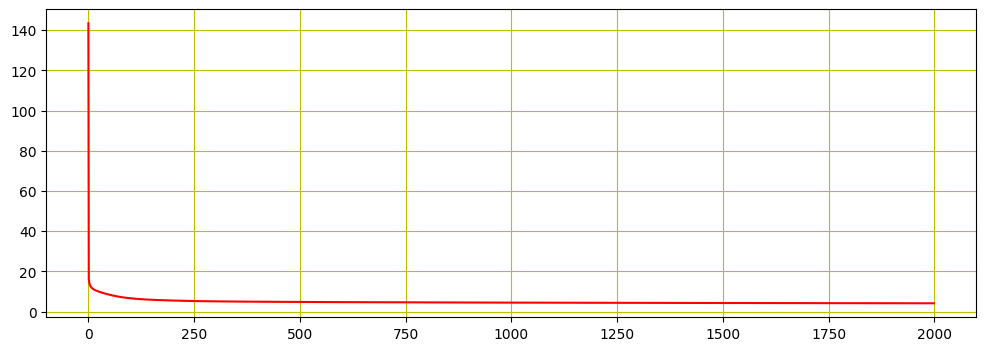

In [ ]:
lr = 0.02
n_epochs = 2000

r=3
W = torch.randn((n,r), requires_grad=True, dtype=torch.float, device=device)
H = torch.randn((r,d), requires_grad=True, dtype=torch.float, device=device)


optimizer = torch.optim.SGD([W, H], lr=lr)
#optimizer = torch.optim.Adam([W, H], lr=lr)

loss_list = []

for epoch in range(n_epochs):


    # loss=torch.mean(torch.pow(Z-torch.matmul(W,H),2))   ## <- OLD


    W2 = torch.exp(W)
    H2 = torch.exp(H)

    loss=torch.mean(torch.pow(Z-torch.matmul(W2,H2),2))


    loss.backward()

    optimizer.step()
    optimizer.zero_grad()
    loss_list.append(loss.item())

print(loss)


#fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,4))
plt.figure(figsize=(12,4))
plt.plot(loss_list, 'r')
plt.grid('True', color='y')


final_loss_nonneg=loss.item()
print("final_loss = ", final_loss)
print("final_loss_nonneg = ", final_loss_nonneg)

In [ ]:
# Final matrices:
W2 = torch.exp(W)
H2 = torch.exp(H)

In [ ]:
print(W2)
print(H2)


tensor([[2.1311, 0.5437, 1.0288],
        [3.5081, 0.1775, 0.2187],
        [0.3145, 1.4366, 1.9952],
        [1.8245, 1.8929, 0.0994],
        [0.5375, 0.5150, 1.9930],
        [1.6158, 1.3394, 0.7493],
        [0.5464, 4.2526, 0.4001],
        [0.4246, 1.3059, 2.0006],
        [0.3279, 3.2539, 0.1583],
        [0.1540, 0.3393, 2.7650],
        [0.1384, 0.8147, 1.4353]], grad_fn=<ExpBackward0>)
tensor([[0.2003, 0.5606, 2.0046, 1.3296, 1.6827, 0.3586, 0.1481, 0.9108, 2.1858,
         0.3647, 1.7208, 2.5719, 0.5254, 0.8641, 0.3445],
        [1.9414, 1.8353, 0.2105, 0.2315, 1.4410, 1.4445, 0.9370, 1.5853, 1.2630,
         1.3289, 0.7110, 0.7301, 0.9802, 1.4935, 0.5271],
        [0.5802, 0.9767, 1.3649, 1.8439, 0.4342, 2.9558, 2.9046, 0.9989, 0.3942,
         0.4520, 2.8221, 1.6264, 0.3127, 0.2584, 2.0230]],
       grad_fn=<ExpBackward0>)


# Q5.3
* Approximate the same  $\mathbf{Z}$ as
$$\mathbf{Z}\approx \mathbf{W}\mathbf{H}$$
where $\mathbf{W}$ is of size $n\times r$ and $\mathbf{H}$ is of size $r\times d$ (fix some $r<d$) so that
* a) $\mathbf{W}$ is a symmetric matrix
* b) $\mathbf{W}$ is a symmetric matrix with nonnegative entries
* c) $\mathbf{W}$ is symmetric and each entry of $\mathbf{H}$ is at least 0.5


In [ ]:
#macierz symetryczna musi być kwadratowa, więc r=n

# Z jest kształtu nxd, 11x15 zatem r=11<15

def sgd_symmetric(Z,m):
  lr = 0.02
  n_epochs = 2000
  W = torch.randn((n,m), requires_grad=True, dtype=torch.float, device=device)
  H = torch.randn((n,d), requires_grad=True, dtype=torch.float, device=device)
  optimizer = torch.optim.SGD([W, H], lr=lr)
  #optimizer = torch.optim.Adam([W, H], lr=lr)

  for epoch in range(n_epochs):

      loss=torch.mean(torch.pow(Z-torch.matmul(torch.matmul(W, W.t()),H),2))
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
  return torch.matmul(torch.matmul(W, W.t()),H).detach().numpy(), torch.matmul(W, W.t()), H.detach().numpy()


Z_approx,W_result, H_result=sgd_symmetric(Z,3)

print(W_result.shape)
print(W_result.T-W_result) #zatem W jest symetryczna


torch.Size([11, 11])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], grad_fn=<SubBackward0>)


In [ ]:
#macierz symetryczna musi być kwadratowa, więc r=n

# Z jest kształtu nxd, 11x15 zatem r=11<15

def sgd_symmetric_nonnegative(Z,m):
  lr = 10e-7
  n_epochs = 2000
  W_prim = torch.randn((n,m), requires_grad=True, dtype=torch.float, device=device)
  H = torch.randn((n,d), requires_grad=True, dtype=torch.float, device=device)
  optimizer = torch.optim.SGD([W_prim, H], lr=lr)
  #optimizer = torch.optim.Adam([W, H], lr=lr)

  for epoch in range(n_epochs):
      W=torch.matmul(W_prim, W_prim.t())
      W_exp=torch.exp(W)
      loss=torch.mean(torch.pow(Z-torch.matmul(W_exp,H),2))
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

  W=torch.matmul(W_prim, W_prim.t())
  W_exp=torch.exp(W)
  return torch.matmul(W_exp,H).detach().numpy(), W_exp.detach().numpy(), H.detach().numpy()


Z_approx2,W_result2, H_result2 =sgd_symmetric_nonnegative(Z,3)


print(W_result2.shape)
print(W_result2.T-W_result2)
print(W_result2)
print(np.all(W_result2>0))


(11, 11)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[ 7.5985317   0.53642213  0.77714276  0.27800357  1.324909    3.2432024
   7.4276443   0.10488161  1.458561    2.2750907   0.23160478]
 [ 0.53642213  2.8603466   1.912112    3.5643005   0.78852916  0.3175495
   0.46101886  1.9293898   1.9274408   2.6251636   0.9548009 ]
 [ 0.77714276  1.912112    1.7412655   1.639192    0.90171504  0.7183872
   0.65363705  1.3107927   1.8980772   2.283332    0.55303395]
 [ 0.27800357  3.5643005   1.639192    8.413881    0.67926836  0.11953321
   0.27084616  3.9106617   1.2833354   1.6810274   3.260425  ]
 [ 1.324909    0.78852916  0.90171504  0.67926836

In [ ]:
#macierz symetryczna musi być kwadratowa, więc r=n

# Z jest kształtu nxd, 11x15 zatem r=11<15

def sgd_symmetric_nonnegative2(Z,m):
  lr = 10e-9
  n_epochs = 2000
  W_prim = torch.randn((n,m), requires_grad=True, dtype=torch.float, device=device)
  H = torch.randn((n,d), requires_grad=True, dtype=torch.float, device=device)
  optimizer = torch.optim.SGD([W_prim, H], lr=lr)
  #optimizer = torch.optim.Adam([W, H], lr=lr)

  for epoch in range(n_epochs):
      W=torch.matmul(W_prim, W_prim.t())
      W_exp=torch.exp(W)
      new_W= W_exp+torch.full(W_exp.shape, 0.5)
      loss=torch.mean(torch.pow(Z-torch.matmul(new_W,H),2))
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

  W=torch.matmul(W_prim, W_prim.t())
  W_exp=torch.exp(W)
  new_W= W_exp+torch.full(W_exp.shape, 0.5)
  return torch.matmul(new_W,H).detach().numpy(), new_W.detach().numpy(), H.detach().numpy()


Z_approx3,W_result3, H_result3 =sgd_symmetric_nonnegative2(Z,3)


print(W_result3.shape)
print(W_result3.T-W_result3)
print(W_result3)
print(np.all(W_result3>0.5))


(11, 11)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[22.449507    2.5589235   3.511374    1.1738331   0.6937177   0.61653024
   0.78682315  0.8878046   0.60327446 14.223208    1.0335082 ]
 [ 2.5589235  86.294334    2.78384     1.6583062   1.0083065   0.71157825
  14.937106    0.74257886  0.5289474   7.3581204   0.5944716 ]
 [ 3.511374    2.78384     4.4421806   1.2606099   0.70069516  2.4233599
   1.8127224   1.4110485   1.0940487   1.576912    0.86608815]
 [ 1.1738331   1.6583062   1.2606099   1.5983192   1.9508783   1.4340539
   1.8045701   1.4810143   1.4964621   1.4296982   1.5464926 ]
 [ 0.6937177   1.0083065   0.70069516  1.9508783

In [ ]:
for i in range (2,3):
  print(i)
  Z_org=Z.detach().numpy()
  print("1: ", np.linalg.norm(sgd_symmetric(Z, i)[0]-Z_org, 'fro'))
  print("2: ", np.linalg.norm(sgd_symmetric_nonnegative(Z, i)[0]-Z_org, 'fro'))
  print("3: ", np.linalg.norm(sgd_symmetric_nonnegative2(Z, i)[0]-Z_org, 'fro'))

2
1:  27.915910710263166
2:  111.78084611903022
3:  289.34791729697
